## **题目3：CT猎人：医学影像报告异常检测**
#### 一、导入必要的库

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

#### 二、设置随机种子以确保可复现性

In [16]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#### 三、设置设备

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cpu


#### 四、数据集类

In [18]:
class CTDataset(Dataset):
    def __init__(self, descriptions, labels=None):
        self.descriptions = descriptions
        self.labels = labels
        
    def __len__(self):
        return len(self.descriptions)
    
    def __getitem__(self, idx):
        desc = self.descriptions[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return desc, label
        return desc

#### 五、位置编码类

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        if max_len is None:
            max_len = 5000
            
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

#### 六、学习率查找器
**参数**:

    model_class: 模型的类 (例如 CTClassifier 或 TransformerClassifier)
    model_params: 一个字典，包含传递给模型构造函数的参数 (例如 vocab_size, embedding_dim, ...)
    train_loader: 训练数据加载器
    criterion: 损失函数
    device: 'cuda' 或 'cpu'
    init_lr: 初始学习率
    final_lr: 最终学习率
    num_steps: 在多少步内从 init_lr 增加到 final_lr

#### 七、修正的数据加载与预处理函数

In [20]:
def load_data(train_path, test_path=None):
    # 加载训练数据，使用'|'作为分隔符
    col_names = ['report_ID', 'description', 'label']
    train_df = pd.read_csv(train_path, sep=r'\|,\|', header=None, names=col_names, engine='python', dtype=str)
    # 确认实际有3列数据（report_ID, description, label）
    train_df.columns = ['report_ID', 'description', 'label']
    
    # 处理description列，将字符串转换为整数列表
    train_descriptions = []
    for desc in train_df['description'].values:
        if pd.isna(desc) or desc.strip() == '':
            tokens = []
        else:
            tokens = list(map(int, desc.strip().split()))
        train_descriptions.append(tokens)
    
    # 处理标签列
    train_labels = np.zeros((len(train_df), 17))
    for i, label_str in enumerate(train_df['label'].values):
        if pd.notna(label_str) and label_str.strip() != '':
            valid_labels = [l for l in str(label_str).strip().split() if l]
            for label in label_str.strip().split():
                train_labels[i, int(label)] = 1
    
    # 统计数据特征
    seq_lengths = [len(desc) for desc in train_descriptions]
    max_seq_len = max(seq_lengths) if seq_lengths else 0
    vocab_size = 0
    if train_descriptions:
        all_tokens = [token for desc in train_descriptions if desc for token in desc]
        if all_tokens:
            vocab_size = max(all_tokens) + 1
        else:
            vocab_size = 1 # 避免词汇表大小为0
    else:
        vocab_size = 1
    print(f"训练集大小: {len(train_df)}")
    if seq_lengths:
        print(f"序列平均长度: {np.mean(seq_lengths):.2f}")
        print(f"序列最大长度: {max_seq_len}")
        print(f"序列最小长度: {min(seq_lengths)}")
    else:
        print("序列统计信息：数据为空或所有序列为空")
    print(f"词汇表大小: {vocab_size}")
    
    # 标签分布
    label_dist = train_labels.sum(axis=0)
    print("各区域异常标签分布:")
    for i, count in enumerate(label_dist):
        print(f"区域 {i}: {count} 例 ({count/len(train_df)*100:.2f}%)")
    
    # 加载测试数据（如果提供）
    test_descriptions = None
    test_report_ids = None
    if test_path:
        test_df = pd.read_csv(test_path, sep=r'\|,\|', header=None, names=col_names, engine='python', dtype=str)
        test_report_ids = test_df['report_ID'].values

        test_descriptions = []
        for desc in test_df['description'].values:
            if pd.isna(desc) or str(desc).strip() == '':
                tokens = []
            else:
                tokens = list(map(int, str(desc).strip().split()))
            test_descriptions.append(tokens)
        print(f"测试集大小: {len(test_df)}")
    
    return train_descriptions, train_labels, test_descriptions, test_report_ids, vocab_size, max_seq_len

#### 八、批次数据进行填充

In [21]:
def collate_fn(batch):
    if isinstance(batch[0], tuple):  # 训练模式，有标签
        descriptions = [item[0] for item in batch]
        labels_list_of_ndarrays = [item[1] for item in batch]
        labels_np_array = np.array(labels_list_of_ndarrays) # 先转换为单个NumPy数组
        labels = torch.tensor(labels_np_array, dtype=torch.float32) # 再转换为Tensor
        
        # 计算这个批次中的最大长度
        max_len = max(len(desc) for desc in descriptions) if descriptions and all(desc for desc in descriptions) else 1
        
        # 填充序列
        padded_descs = []
        attention_masks = []
        for desc in descriptions:
            padded_desc = desc + [0] * (max_len - len(desc))
            attention_mask = [1] * len(desc) + [0] * (max_len - len(desc))
            padded_descs.append(padded_desc)
            attention_masks.append(attention_mask)
            
        padded_descs = torch.tensor(padded_descs, dtype=torch.long)
        attention_masks = torch.tensor(attention_masks, dtype=torch.float32)
        
        return padded_descs, attention_masks, labels
    else:  # 测试模式，无标签
        descriptions = batch
        max_len = max(len(desc) for desc in descriptions) if descriptions and all(desc for desc in descriptions) else 1
        
        padded_descs = []
        attention_masks = []
        for desc in descriptions:
            padded_desc = desc + [0] * (max_len - len(desc))
            attention_mask = [1] * len(desc) + [0] * (max_len - len(desc))
            padded_descs.append(padded_desc)
            attention_masks.append(attention_mask)
            
        padded_descs = torch.tensor(padded_descs, dtype=torch.long)
        attention_masks = torch.tensor(attention_masks, dtype=torch.float32)
        
        return padded_descs, attention_masks

#### 九、定义LSTM模型

In [22]:
class CTClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, num_classes):
        super(CTClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # 双向LSTM，输出维度乘2
        
    def forward(self, x, attention_mask):
        # x: [batch_size, seq_len]
        # attention_mask: [batch_size, seq_len]
        
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # 应用注意力掩码：将padding部分的embedding置为0
        embedded = embedded * attention_mask.unsqueeze(2)
        
        # LSTM层
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim*2]
        
        # 使用序列中的最后一个非padding元素的输出
        seq_lengths = attention_mask.sum(dim=1).long()
        batch_size = x.size(0)
        
        # 获取每个序列中最后一个非padding元素的索引
        idx = (seq_lengths - 1).view(-1, 1).expand(batch_size, lstm_out.size(2))
        idx = idx.unsqueeze(1)
        
        # 收集最后一个非padding元素的输出
        last_hidden = lstm_out.gather(1, idx).squeeze(1)
        
        # Dropout和全连接层
        last_hidden = self.dropout(last_hidden)
        logits = self.fc(last_hidden)  # [batch_size, num_classes]
        
        # 使用sigmoid激活函数得到每个类别的概率
        return torch.sigmoid(logits)

#### 十、定义Transformer模型

In [23]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, nhead, num_layers, dim_feedforward, dropout_rate, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_rate, max_len=256) # 假设你的最大序列长度是512或更小

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x, attention_mask):
        # x: [batch_size, seq_len]
        # attention_mask: [batch_size, seq_len]
        
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = self.pos_encoder(embedded) # <--- 添加这一行
        
        # 创建Transformer的注意力掩码（注意这里掩码的定义与之前不同）
        # 在Transformer中，1表示要遮盖的位置，0表示要保留的位置
        transformer_mask = (1.0 - attention_mask).bool()
        
        # 应用Transformer编码器
        transformer_out = self.transformer_encoder(embedded, src_key_padding_mask=transformer_mask)
        
        # 计算池化后的表示
        # 这里使用注意力掩码来进行平均池化，只考虑非填充的token
        expanded_mask = attention_mask.unsqueeze(-1)
        masked_output = transformer_out * expanded_mask
        sum_embeddings = masked_output.sum(1)
        sum_mask = expanded_mask.sum(1)
        # 防止除以0
        sum_mask = torch.clamp(sum_mask, min=1.0)
        pooled_output = sum_embeddings / sum_mask
        
        # Dropout和全连接层
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)  # [batch_size, num_classes]
        
        # 使用sigmoid激活函数得到每个类别的概率
        return logits

#### 十一、训练函数

In [24]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_path, scheduler=None):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch in progress_bar:
            inputs, attention_masks, labels = batch
            inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(inputs, attention_masks)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in progress_bar:
                inputs, attention_masks, labels = batch
                inputs, attention_masks, labels = inputs.to(device), attention_masks.to(device), labels.to(device)
                
                outputs = model(inputs, attention_masks)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                progress_bar.set_postfix({'loss': loss.item()})
                
                all_labels.append(labels.cpu().numpy())
                all_preds.append(outputs.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # 计算验证集上的AUC
        all_labels = np.vstack(all_labels)
        all_preds = np.vstack(all_preds)
        
        # 计算每个类别的AUC
        aucs = []
        for i in range(all_labels.shape[1]):
            # 检查该类别是否有正样本和负样本
            if np.sum(all_labels[:, i]) > 0 and np.sum(all_labels[:, i]) < len(all_labels):
                auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                aucs.append(auc)
        
        # 计算平均AUC
        mean_auc = np.mean(aucs) if aucs else 0
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val AUC: {mean_auc}')
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(mean_auc) # 基于验证AUC调整学习率 (因为 mode='max')
                                         # 如果你的 scheduler mode='min'，则用 val_loss
        current_lr = optimizer.param_groups[0]['lr']
        print(f'  Current Learning Rate for Epoch {epoch+1}: {current_lr}') # 使用科学计数法打印，更清晰
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f'Model saved to {model_path}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('loss_curve.png')
    
    return train_losses, val_losses

#### 十二、预测函数

In [25]:
def predict(model, test_loader):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Predicting'):
            inputs, attention_masks = batch
            inputs, attention_masks = inputs.to(device), attention_masks.to(device)
            
            logits = model(inputs, attention_masks) # 模型现在返回 logits
            probabilities = torch.sigmoid(logits)   # <--- 在这里转换为概率
            all_preds.append(probabilities.cpu().numpy()) # 保存概率
    
    return np.vstack(all_preds) # 返回概率的 NumPy 数组

#### 十三、主函数

In [26]:
def main(train_path, test_path, model_type='transformer', batch_size=32, epochs=10, lr=0.001,
         embedding_dim=128, hidden_dim=128, num_layers=2, dropout_rate=0.3,
         nhead=8, dim_feedforward=1024, output_file='predictions.csv', weight_decay=0.0, use_lr_scheduler=False, scheduler_patience=2, scheduler_factor=0.2):
    # 加载数据
    train_descriptions, train_labels, test_descriptions, test_report_ids, vocab_size, max_seq_len = load_data(train_path, test_path)
    
    # 确保词汇表大小至少为1
    vocab_size = max(vocab_size, 1)
    
    # 划分训练集和验证集
    val_size = int(0.1 * len(train_descriptions))
    indices = list(range(len(train_descriptions)))
    np.random.shuffle(indices)
    
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]
    
    train_descs = [train_descriptions[i] for i in train_indices]
    train_labs = train_labels[train_indices]
    
    val_descs = [train_descriptions[i] for i in val_indices]
    val_labs = train_labels[val_indices]
    
    # 创建数据集和数据加载器
    train_dataset = CTDataset(train_descs, train_labs)
    val_dataset = CTDataset(val_descs, val_labs)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    num_classes = 17
    
    # 创建模型
    
    if model_type == 'lstm':
        model = CTClassifier(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout_rate=dropout_rate,
            num_classes=num_classes
        )
        model_path = 'ct_lstm_model.pth'
    else:  # transformer
        model = TransformerClassifier(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout_rate=dropout_rate,
            num_classes=num_classes
        )
        model_path = 'ct_transformer_model.pth'
    
    model = model.to(device)
    
    # 优化器和损失函数
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss() 

    # --- 学习率调度器 ---
    scheduler = None # 初始化为 None
    if args.use_lr_scheduler: # args.use_lr_scheduler 是从命令行解析的 bool(0) 或 bool(1)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max',        # 因为我们监控 AUC，所以是 'max'
            factor=args.scheduler_factor, 
            patience=args.scheduler_patience, 
            #verbose=True
        )
        print("学习率调度器 ReduceLROnPlateau 已启用。")
    else:
        print("未使用学习率调度器。")

    """
    common_model_params = {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'num_layers': num_layers,
        'dropout_rate': dropout_rate,
        'num_classes': num_classes
    }
    if model_type == 'lstm':
        model_class = CTClassifier
        model_specific_params = {'hidden_dim': hidden_dim}
        model_path = 'ct_lstm_model.pth'
    else:  # transformer
        model_class = TransformerClassifier
        model_specific_params = {'nhead': nhead, 'dim_feedforward': dim_feedforward}
        # 注意：Transformer 的 d_model 通常就是 embedding_dim
        # TransformerEncoderLayer 的 dropout 是参数，TransformerEncoder 本身没有
        model_path = 'ct_transformer_model.pth'
    
    current_model_params = {**common_model_params, **model_specific_params}

    criterion = nn.BCEWithLogitsLoss() # BCELoss 用于 sigmoid 输出
    find_lr(
            model_class=model_class,
            model_params=current_model_params,
            train_loader=train_loader, # 使用完整的训练加载器
            criterion=criterion,
            device=device,
            num_steps=100 # 可以根据 len(train_loader) 调整，例如 min(100, len(train_loader) -1)
        )
    print("学习率查找完成。请查看 lr_finder_plot.png 并根据图像选择学习率。")
    print("现在将退出程序。请修改 --lr 参数并重新运行进行训练。")
    return # 查找完LR后直接退出，不进行后续训练
    """

    # 训练模型
    train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=epochs, model_path=model_path, scheduler=scheduler)
    
    # 加载最佳模型
    model.load_state_dict(torch.load(model_path))
    
    # 在测试集上进行预测
    if test_descriptions:
        test_dataset = CTDataset(test_descriptions)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
        
        predictions = predict(model, test_loader)
        
        # 保存预测结果
        # 1. 将17维概率向量转换为单个空格分隔的字符串
        probability_strings = []
        for i in range(predictions.shape[0]): # predictions 是一个 (n_samples, 17) 的 NumPy 数组
            # 将当前行的17个浮点数概率转换为字符串，并用空格连接
            # str(p) 会自动处理浮点数的显示，包括科学计数法（如你例子所示）
            current_prob_str = ' '.join([str(p) for p in predictions[i, :]])
            probability_strings.append(current_prob_str)
            
        # 2. 创建一个包含两列的 DataFrame：report_ID 和格式化后的概率字符串
        # test_report_ids 应该是一个列表或一维NumPy数组，包含所有测试样本的ID
        output_df = pd.DataFrame({
            'report_ID': test_report_ids,
            'probabilities': probability_strings
        })
        
        # 3. 保存到 CSV，不带表头，不带索引，使用 '|,|' 作为分隔符
        output_df.to_csv(output_file, header=False, index=False, sep='|')
        
        print(f'Predictions saved to {output_file}')

#### 十四、设置参数

In [27]:
class Args:
    train = 'combined_train_data.csv'
    test = 'track1_round1_testB.csv'
    model = 'transformer'
    batch_size = 64
    epochs = 15
    lr = 0.00141
    embedding_dim = 256
    hidden_dim = 256
    num_layers = 2
    dropout = 0.3
    output = 'predictions.csv'
    weight_decay = 1e-5
    nhead = 4
    dim_feedforward = 512
    use_lr_scheduler = 0
    scheduler_patience = 2
    scheduler_factor = 0.99

args = Args()


#### 十五、运行测试

训练集大小: 30000
序列平均长度: 36.53
序列最大长度: 136
序列最小长度: 2
词汇表大小: 858
各区域异常标签分布:
区域 0: 3991.0 例 (13.30%)
区域 1: 3017.0 例 (10.06%)
区域 2: 2275.0 例 (7.58%)
区域 3: 973.0 例 (3.24%)
区域 4: 4137.0 例 (13.79%)
区域 5: 837.0 例 (2.79%)
区域 6: 474.0 例 (1.58%)
区域 7: 3933.0 例 (13.11%)
区域 8: 2938.0 例 (9.79%)
区域 9: 2266.0 例 (7.55%)
区域 10: 894.0 例 (2.98%)
区域 11: 3894.0 例 (12.98%)
区域 12: 856.0 例 (2.85%)
区域 13: 540.0 例 (1.80%)
区域 14: 1195.0 例 (3.98%)
区域 15: 6043.0 例 (20.14%)
区域 16: 1451.0 例 (4.84%)
测试集大小: 3000
未使用学习率调度器。


Epoch 1/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 13.00it/s, loss=0.228]


Epoch 1/15, Train Loss: 0.20878789923484856, Val Loss: 0.18962898691917987, Val AUC: 0.8378727914677299
  Current Learning Rate for Epoch 1: 0.00141
Model saved to ct_transformer_model.pth


Epoch 2/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.53it/s, loss=0.185]


Epoch 2/15, Train Loss: 0.17128398867933106, Val Loss: 0.16129921487671264, Val AUC: 0.8858129387576996
  Current Learning Rate for Epoch 2: 0.00141
Model saved to ct_transformer_model.pth


Epoch 3/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.89it/s, loss=0.183]


Epoch 3/15, Train Loss: 0.1585130963951208, Val Loss: 0.15421032176372854, Val AUC: 0.8919633482059626
  Current Learning Rate for Epoch 3: 0.00141
Model saved to ct_transformer_model.pth


Epoch 4/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.80it/s, loss=0.192]


Epoch 4/15, Train Loss: 0.15250261106762275, Val Loss: 0.1482811505173115, Val AUC: 0.906277751068122
  Current Learning Rate for Epoch 4: 0.00141
Model saved to ct_transformer_model.pth


Epoch 5/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.18it/s, loss=0.188]


Epoch 5/15, Train Loss: 0.14990504730439863, Val Loss: 0.15554447123344908, Val AUC: 0.9063043630932204
  Current Learning Rate for Epoch 5: 0.00141


Epoch 6/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.91it/s, loss=0.19] 


Epoch 6/15, Train Loss: 0.14739738000442065, Val Loss: 0.14954030022342155, Val AUC: 0.9129076585695944
  Current Learning Rate for Epoch 6: 0.00141


Epoch 7/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s, loss=0.207]


Epoch 7/15, Train Loss: 0.14599992371919032, Val Loss: 0.15123953210546615, Val AUC: 0.9127261031987725
  Current Learning Rate for Epoch 7: 0.00141


Epoch 8/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.79it/s, loss=0.211]


Epoch 8/15, Train Loss: 0.14503736382623986, Val Loss: 0.1601030002249048, Val AUC: 0.9182172456511253
  Current Learning Rate for Epoch 8: 0.00141


Epoch 9/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 13.10it/s, loss=0.197]


Epoch 9/15, Train Loss: 0.14522503899030775, Val Loss: 0.1543304132337266, Val AUC: 0.9200204607477821
  Current Learning Rate for Epoch 9: 0.00141


Epoch 10/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.41it/s, loss=0.188]


Epoch 10/15, Train Loss: 0.14414479613516004, Val Loss: 0.14725734436131538, Val AUC: 0.9211503811850953
  Current Learning Rate for Epoch 10: 0.00141
Model saved to ct_transformer_model.pth


Epoch 11/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.99it/s, loss=0.168]


Epoch 11/15, Train Loss: 0.14717691292836202, Val Loss: 0.14656021556955703, Val AUC: 0.91261930153165
  Current Learning Rate for Epoch 11: 0.00141
Model saved to ct_transformer_model.pth


Epoch 12/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 13.03it/s, loss=0.167]


Epoch 12/15, Train Loss: 0.1472757593397563, Val Loss: 0.14432099699339968, Val AUC: 0.9236632016963688
  Current Learning Rate for Epoch 12: 0.00141
Model saved to ct_transformer_model.pth


Epoch 13/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 12.66it/s, loss=0.171]


Epoch 13/15, Train Loss: 0.14694447162168287, Val Loss: 0.14728709135917908, Val AUC: 0.9197719196741952
  Current Learning Rate for Epoch 13: 0.00141


Epoch 14/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s, loss=0.166] 


Epoch 14/15, Train Loss: 0.15026068434966683, Val Loss: 0.14425869618958614, Val AUC: 0.9230756867954161
  Current Learning Rate for Epoch 14: 0.00141
Model saved to ct_transformer_model.pth


Epoch 15/15 [Val]: 100%|██████████| 47/47 [00:03<00:00, 13.24it/s, loss=0.154]


Epoch 15/15, Train Loss: 0.14324217642794287, Val Loss: 0.14526904406065635, Val AUC: 0.9238870374669665
  Current Learning Rate for Epoch 15: 0.00141


Predicting: 100%|██████████| 47/47 [00:03<00:00, 12.51it/s]


Predictions saved to predictions.csv


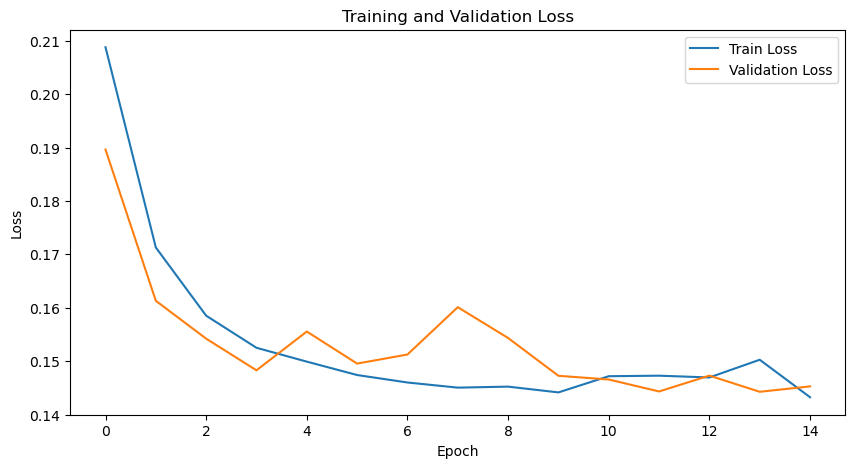

In [28]:
if __name__ == "__main__":
    """
    # 命令行参数处理
    import argparse
    
    parser = argparse.ArgumentParser(description='CT影像文本多标签分类模型')
    parser.add_argument('--train', type=str, default='track1_round1_train_20210222.csv', help='训练数据文件路径')
    parser.add_argument('--test', type=str, default='track1_round1_testB.csv', help='测试数据文件路径')
    parser.add_argument('--model', type=str, default='transformer', choices=['lstm', 'transformer'], 
                        help='模型类型: lstm 或 transformer')
    parser.add_argument('--batch_size', type=int, default=64, help='批次大小')
    parser.add_argument('--epochs', type=int, default=15, help='训练轮数')
    parser.add_argument('--lr', type=float, default=0.0014, help='学习率')
    parser.add_argument('--embedding_dim', type=int, default=256, help='嵌入层维度')
    parser.add_argument('--hidden_dim', type=int, default=256, help='隐藏层维度')
    parser.add_argument('--num_layers', type=int, default=2, help='层数')
    parser.add_argument('--dropout', type=float, default=0.3, help='Dropout比例')
    parser.add_argument('--output', type=str, default='predictions.csv', help='预测结果输出文件')
    parser.add_argument('--weight_decay', type=float, default=1e-5, help='优化器的权重衰减系数 (L2正则化), 例如 1e-5, 1e-4')
    # Transformer 特有参数 (确保它们存在)
    parser.add_argument('--nhead', type=int, default=4, help='Transformer nhead (Transformer only)')
    parser.add_argument('--dim_feedforward', type=int, default=512, help='Transformer dim_feedforward (Transformer only)')
    
    # 学习率调度器参数
    parser.add_argument('--use_lr_scheduler', type=int, default=0, help='是否使用学习率调度器 (0: 不使用, 1: 使用)')
    parser.add_argument('--scheduler_patience', type=int, default=2, help='学习率调度器的耐心参数')
    parser.add_argument('--scheduler_factor', type=float, default=0.99, help='学习率调度器的缩放因子')

    args = parser.parse_args()
    """
    
    # 运行主函数
    main(args.train, args.test, model_type=args.model, batch_size=args.batch_size,
         epochs=args.epochs, lr=args.lr, embedding_dim=args.embedding_dim,
         hidden_dim=args.hidden_dim, num_layers=args.num_layers,
         dropout_rate=args.dropout, output_file=args.output, nhead=args.nhead,
         dim_feedforward=args.dim_feedforward, weight_decay=args.weight_decay,
         use_lr_scheduler=bool(args.use_lr_scheduler), # <--- 确保这些已在调用中
         scheduler_patience=args.scheduler_patience,
         scheduler_factor=args.scheduler_factor)